In [1]:
import numpy as np 
import pandas as pd 
df = pd.read_csv('/kaggle/input/2023-data-scientists-salary/ds_salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


* experience_level:当年的工作经验水平       EN> 入门级/初级 MI> 中级/中级 SE> 高级/专家 EX> 行政级/总监
* employment_type:角色的雇佣类型            PT> 兼职       FT> 全职    CT> 合同      FL> 自由职业者

In [2]:
#这里统一用slary_in_usd为标准计量工资
df.drop(columns=['salary', 'salary_currency'], inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary_in_usd       3755 non-null   int64 
 5   employee_residence  3755 non-null   object
 6   remote_ratio        3755 non-null   int64 
 7   company_location    3755 non-null   object
 8   company_size        3755 non-null   object
dtypes: int64(3), object(6)
memory usage: 264.1+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,3755.0,2022.373635,0.691448,2020.0,2022.0,2022.0,2023.0,2023.0
salary_in_usd,3755.0,137570.389880,63055.625278,5132.0,95000.0,135000.0,175000.0,450000.0
remote_ratio,3755.0,46.271638,48.589050,0.0,0.0,0.0,100.0,100.0


In [5]:
df.describe(include='object').T

,count,unique,top,freq
experience_level,3755,4,SE,2516
employment_type,3755,4,FT,3718
job_title,3755,93,Data Engineer,1040
employee_residence,3755,78,US,3004
company_location,3755,72,US,3040
company_size,3755,3,M,3153


# 职位分析

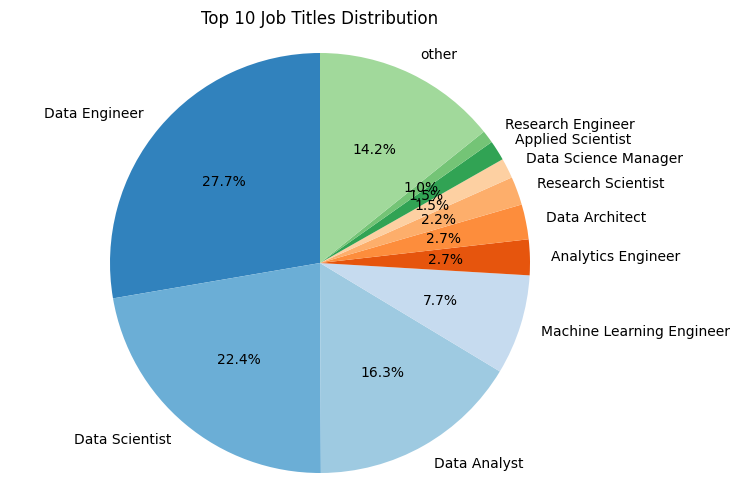

In [6]:
import matplotlib.pyplot as plt

# 计算每个职位的出现次数
job_counts = df['job_title'].value_counts()

# 取前十个职位和其出现次数
top_10_jobs = job_counts.head(10)
other_jobs = job_counts[10:].sum()

# 构建饼图数据
job_labels = top_10_jobs.index.tolist()
job_labels.append('other')
job_sizes = top_10_jobs.tolist()
job_sizes.append(other_jobs)

# 指定颜色
colors = plt.cm.tab20c.colors  # 使用内置的颜色循环

# 绘制饼图
plt.figure(figsize=(8, 6))
plt.pie(job_sizes, labels=job_labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Top 10 Job Titles Distribution')
plt.axis('equal')
plt.show()

job_title中出现最多的职业是data engineer、data scientist、data analyst、machine learning engineer。他们占了75%左右的份额

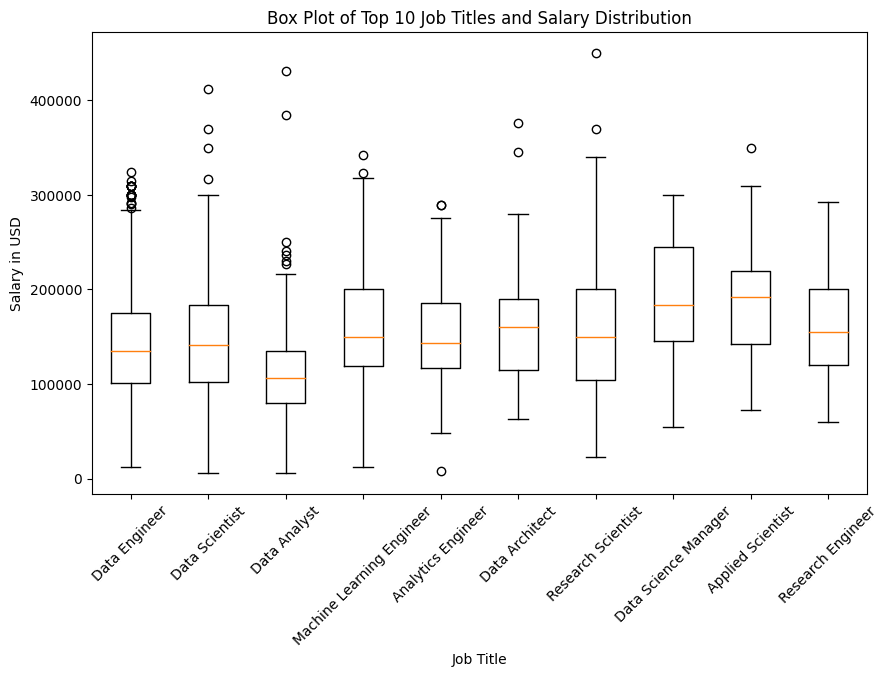

In [7]:
# 计算出现最多的前10个职位
top_10_jobs = df['job_title'].value_counts().head(10).index.tolist()

# 筛选出前十个职位的数据
df_top_10_jobs = df[df['job_title'].isin(top_10_jobs)]

# 绘制箱线图
plt.figure(figsize=(10, 6))
plt.boxplot([df_top_10_jobs[df_top_10_jobs['job_title'] == job]['salary_in_usd'] for job in top_10_jobs], labels=top_10_jobs)
plt.title('Box Plot of Top 10 Job Titles and Salary Distribution')
plt.xlabel('Job Title')
plt.ylabel('Salary in USD')
plt.xticks(rotation=45)
plt.show()

在对数量前十的job_title和salary_in_usd的箱图中可以发现，data analyst的工资水平最低，平均数在100000美元左右。data science manager的工资水平最高，约为160000美元。另一方面，在data analyst、data scientist、research scientist中也有数据点达到了较高水平，可能是由于不同国家、公司规模、工作经验造成的

# 薪资分析

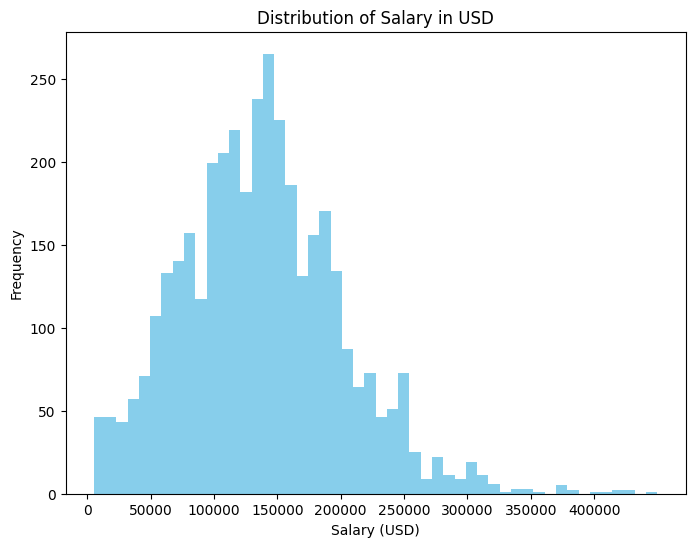

In [8]:
import matplotlib.pyplot as plt

# 绘制直方图
plt.figure(figsize=(8, 6))
plt.hist(df['salary_in_usd'], bins=50, color='skyblue')

# 设置标题和坐标轴标签
plt.title('Distribution of Salary in USD')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')

# 设置 x 轴刻度
plt.xticks(range(0, 450000, 50000))

# 显示图形
plt.show()

总体来看，salary在100000-160000之间出现的频率最高

In [9]:
df['company_location'].value_counts().head()

company_location
US    3040
GB     172
CA      87
ES      77
IN      58
Name: count, dtype: int64

In [10]:
df['employee_residence'].value_counts().head()

employee_residence
US    3004
GB     167
CA      85
ES      80
IN      71
Name: count, dtype: int64

不管从公司方面company_location还是员工方面employee_residence的数量统计结果来看，他们的前五都是：US、GB、CA、ES、IN。所以对这5个国家的工资水平进行分析

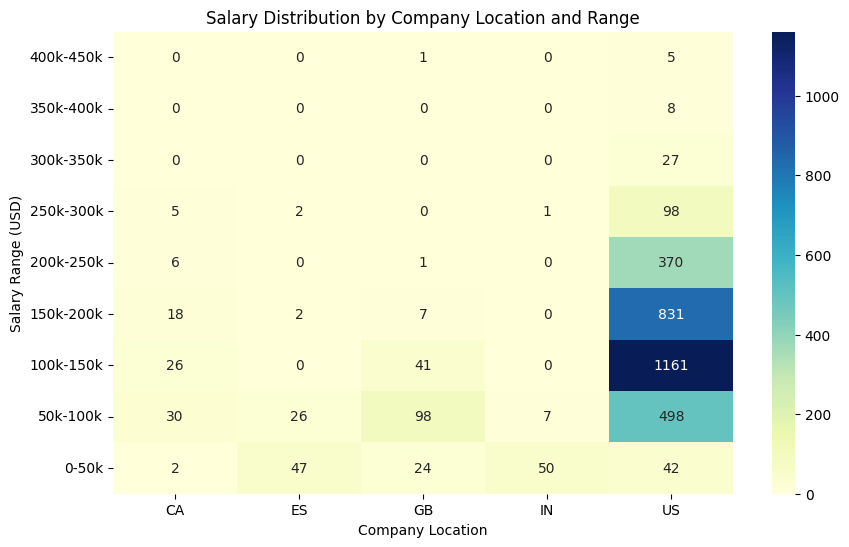

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建新的数据框，对 salary_in_usd 按照指定的范围进行分组
bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000]
labels = ['0-50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k', '250k-300k', '300k-350k', '350k-400k', '400k-450k']
df_new = df[df['company_location'].isin(['US', 'GB', 'CA', 'ES', 'IN'])].copy()
df_new.loc[:, 'salary_range'] = pd.cut(df_new['salary_in_usd'], bins=bins, labels=labels)

# 对数据按照国家和工资水平排序
df_new = df_new.sort_values(by=['company_location', 'salary_range'])

# 生成热力图所需的数据格式
heatmap_data = df_new.groupby(['company_location', 'salary_range']).size().unstack(fill_value=0)

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data.T[::-1], cmap='YlGnBu', annot=True, fmt='d', xticklabels=df_new['company_location'].unique(), yticklabels=labels[::-1])
plt.title('Salary Distribution by Company Location and Range')
plt.xlabel('Company Location')
plt.ylabel('Salary Range (USD)')
plt.show()

美国US数量最多（3000/3700），所以它在company location的频率最高，工资水平基本数据分布与上图的salary整体分布一致，加拿大CA、西班牙ES、英国GB的工资水平基本分布在50k-100k，印度IN的工资水平主要分布在0-50k

# 雇佣类型分析

In [12]:
df['employment_type'].value_counts()

employment_type
FT    3718
PT      17
CT      10
FL      10
Name: count, dtype: int64

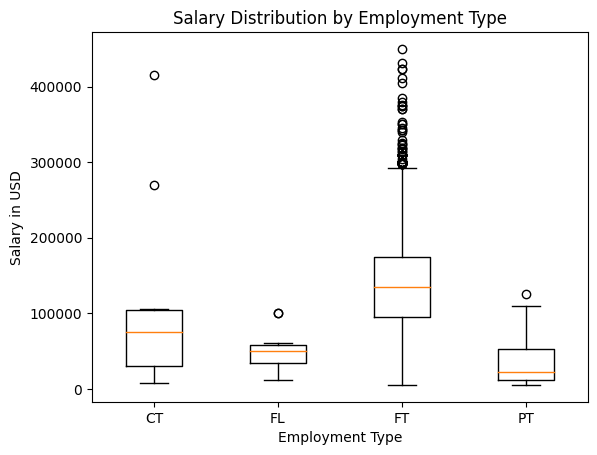

In [13]:
# 按employment_type分组，并获取salary_in_usd列的值
grouped_data = df.groupby('employment_type')['salary_in_usd'].apply(list)

# 绘制箱形图
plt.boxplot(grouped_data.values, labels=grouped_data.index)
plt.xlabel('Employment Type')
plt.ylabel('Salary in USD')
plt.title('Salary Distribution by Employment Type')
plt.show()

从数量来看，全职工作FT占了工作类型employment type的99%以上（3718/3755），从工资来看，全职工作的箱体也明显比其他工作类型高，但是在合同制工作CT中也有少数数据点达到了较高水平，这可能与其项目性质和灵活性有关。

# 公司分析

同样对US、GB、CA、ES、IN进行分析

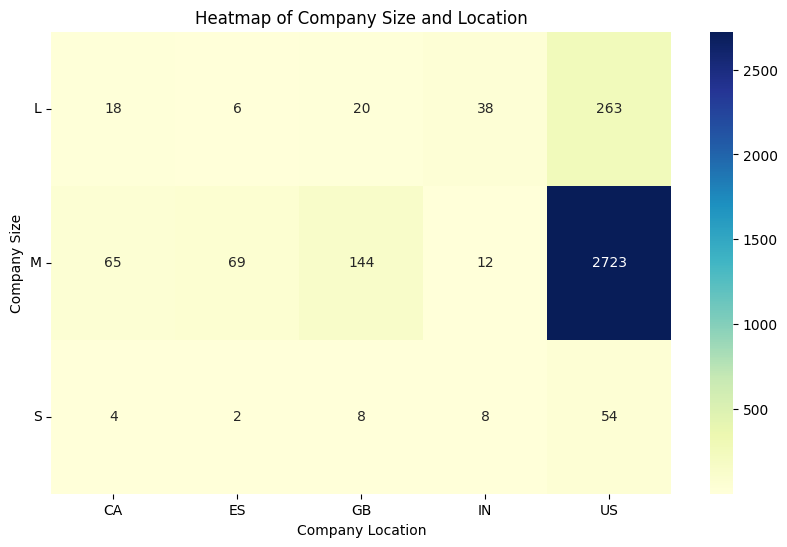

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 过滤符合条件的数据，并创建副本
df_new = df[df['company_location'].isin(['US', 'GB', 'CA', 'ES', 'IN'])].copy()

# 创建交叉表，注意调换行和列的顺序
cross_table = pd.crosstab(df_new['company_size'], df_new['company_location'])

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(cross_table, cmap='YlGnBu', annot=True, fmt='d')
plt.xlabel('Company Location')
plt.ylabel('Company Size')
plt.title('Heatmap of Company Size and Location')
plt.yticks(rotation=0)
plt.show()

排名前5的国家里基本都是中型公司占大多数，只有印度IN是大公司占多数

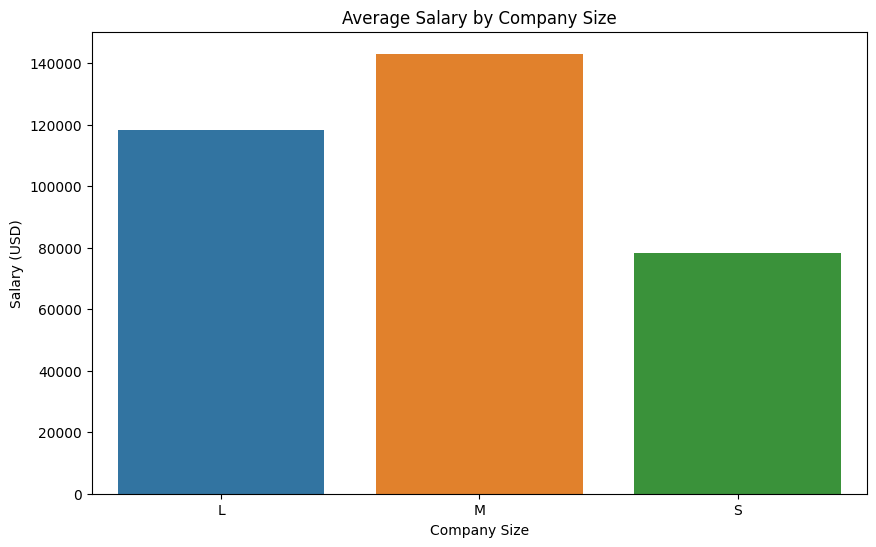

In [15]:
# 根据公司规模分组，计算不同规模公司的薪资、雇佣类型和工作经验水平的均值
grouped_df = df.groupby('company_size').agg({
    'salary_in_usd': 'mean',
    'employment_type': pd.Series.mode,
    'experience_level': pd.Series.mode
}).reset_index()

# 绘制薪资水平柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x='company_size', y='salary_in_usd', data=grouped_df)
plt.xlabel('Company Size')
plt.ylabel('Salary (USD)')
plt.title('Average Salary by Company Size')
plt.show()

薪资水平排名：中型公司M > 大公司L > 小公司S

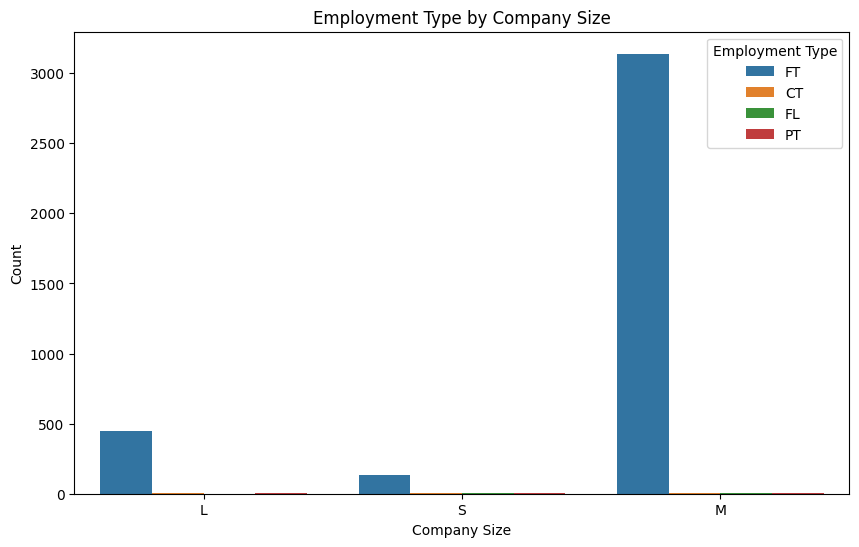

In [16]:
# 绘制雇佣类型和工作经验水平的堆叠柱状图
plt.figure(figsize=(10, 6))
sns.countplot(x='company_size', hue='employment_type', data=df)
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.title('Employment Type by Company Size')
plt.legend(title='Employment Type')
plt.show()

不管是什么规模的公司，基本都是以全职工FT为主

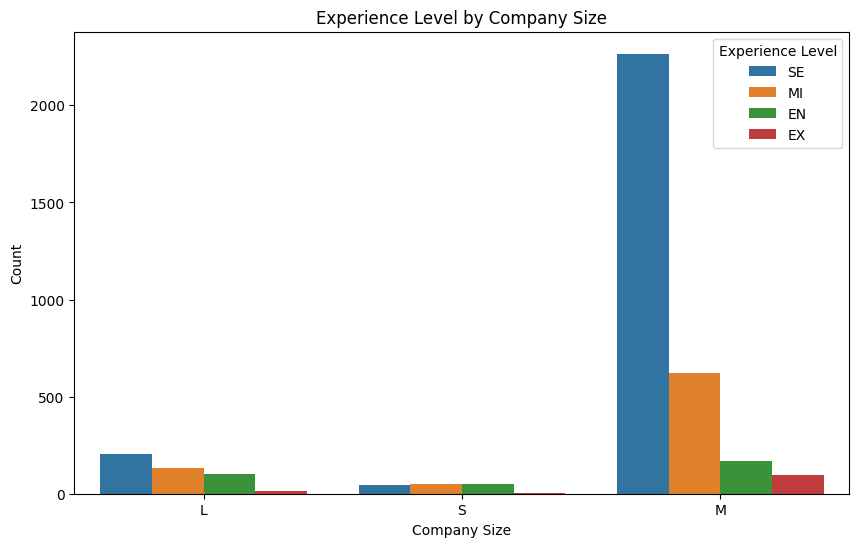

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='company_size', hue='experience_level', data=df)
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.title('Experience Level by Company Size')
plt.legend(title='Experience Level')
plt.show()

在不同规模公司的工作经验数量分布来看，大公司和中型公司都是高级SE > 中级MI > 入门EN > 总监SE的员工经验分布，小公司则是高级SE、中级MI、入门EN的数量几乎相等，而总监EX的数量几乎为零

# 远程工作分析

In [18]:
df['remote_ratio'].value_counts()

remote_ratio
0      1923
100    1643
50      189
Name: count, dtype: int64

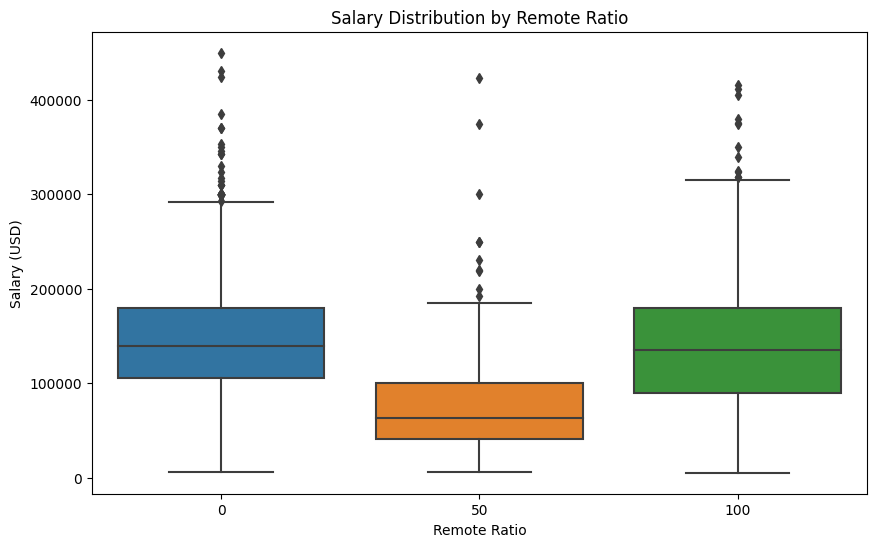

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
# 绘制远程工作职位不同类型的箱图
plt.figure(figsize=(10, 6))
sns.boxplot(x='remote_ratio', y='salary_in_usd', data=df)
plt.xlabel('Remote Ratio')
plt.ylabel('Salary (USD)')
plt.title('Salary Distribution by Remote Ratio')
plt.show()

综上所述，根据数据分析结果，我们可以得出结论：在半远程工作类型中，工资水平最低；而远程工作比例为 0% 的情况下，虽然大部分工资水平与非远程工作比例为 100% 的情况相当，但也存在少数数据点显示较高的工资水平。

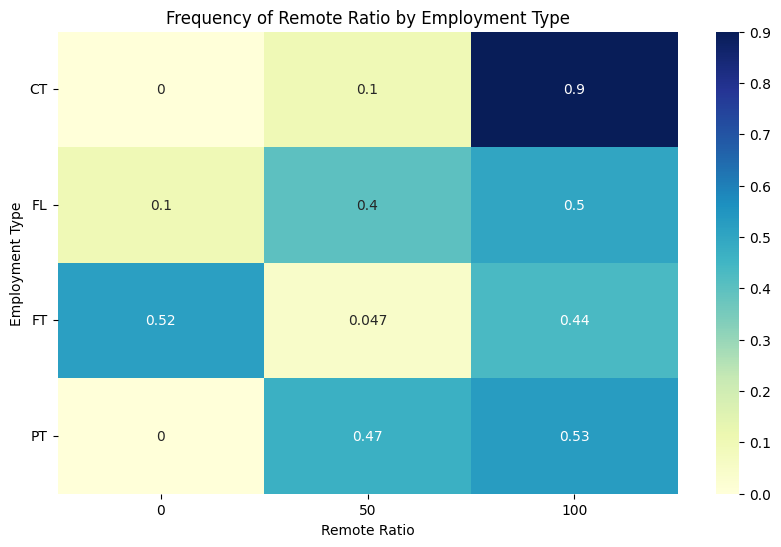

In [20]:
# 使用 crosstab 函数计算频率
frequency_table = pd.crosstab(df['employment_type'], df['remote_ratio'], normalize='index')

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(frequency_table, annot=True, cmap='YlGnBu')
plt.xlabel('Remote Ratio')
plt.ylabel('Employment Type')
plt.title('Frequency of Remote Ratio by Employment Type')
plt.yticks(rotation=0)
plt.show()

在不同的远程办公情况下，不同类型的雇佣方式占据主导地位。全职办公（FT）在非远程办公中占主导地位，兼职（PT）和自由职业者（FL）在半远程工作类型中占主导地位，而合同制办公（CT）在远程办公中占主导地位